In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df1 = pd.read_csv("input/data-attendance-1.txt")

In [3]:
df1.head(2)

,A,Score,Y
0,0,69,0.286
1,1,145,0.196


In [5]:
#http://sinhrks.hatenablog.com/entry/2016/11/01/075527から拝借
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=10):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series) # return the index of unique values list, unique values

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)


    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

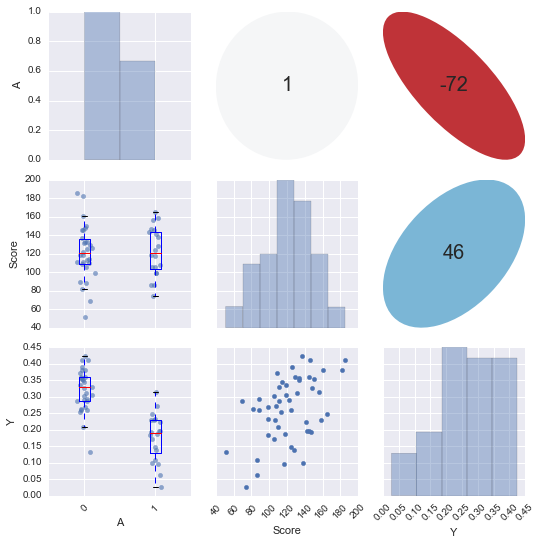

In [6]:
g = sns.PairGrid(df1, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(d.comb)
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

In [6]:
# 書籍通りだと、データが不十分そうなので、データ追加
Score_new = np.arange(50,200)
N_new = len(Score_new)
data = {'N':len(df1), 'N_new': N_new,'A':df1["A"], 'Score':df1["Score"]/200, 'Score_new': Score_new/200,'Y':df1["Y"]}
fit = pystan.stan("stan/model5-3.stan",  data=data, seed=1234)

In [7]:
fit

Inference for Stan model: anon_model_6d8c7e9bab1e9f0233994ed9355da70d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1             0.12  1.2e-3   0.03   0.06    0.1   0.13   0.15   0.19    775    1.0
b2            -0.14  5.0e-4   0.02  -0.17  -0.15  -0.14  -0.13  -0.11    929    1.0
b3             0.32  1.9e-3   0.05   0.22   0.29   0.32   0.36   0.43    785    1.0
sigma          0.05  2.0e-4 5.7e-3   0.04   0.05   0.05   0.06   0.06    847    1.0
mu[0]          0.24  6.1e-4   0.02    0.2   0.22   0.24   0.25   0.27    810    1.0
mu[1]          0.21  4.2e-4   0.01   0.19   0.21   0.21   0.22   0.24   1038    1.0
mu[2]          0.33  2.9e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   1114    1.0
mu[3]          0.12  4.9e-4   0.01   0.09   0.11   0.12   0.13   0.15    922    1.0
mu[4]          0.24  5.0e-4   0.02    0.2   0.23   0.24

#### 5.1.8 図によるモデルのチェック

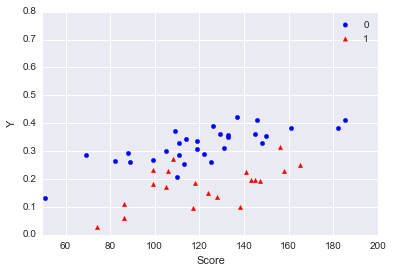

In [8]:
idx_a0 = df1.A == 0
df_a0 = df1[idx_a0]
ax1= plt.scatter(df_a0.Score, df_a0.Y, marker="o", color="b",label="0")
idx_a1 = df1.A == 1
df_a1 = df1[idx_a1]
ax1= plt.scatter(df_a1.Score, df_a1.Y, marker="^", color="r",label="1")
ax1= plt.xlim(50,200)
ax1= plt.ylim(0,0.8)
ax1= plt.xlabel("Score")
ax1= plt.ylabel("Y")
ax1= plt.legend(loc="best")

書籍データ誤り？

In [9]:
ms = fit.extract()

In [10]:
y0_pred = ms["y0_pred"].T
y1_pred = ms["y1_pred"].T

In [11]:
y0_pred.shape

(150, 4000)

In [12]:
N_mcmc = len(ms["lp__"])
x_range = np.arange(0,200,200)
b1 = np.median(ms["b1"])
b2 = np.median(ms["b2"])
b3 = np.median(ms["b3"])
pred0_low80 = []
pred0_upp80 = []
pred0_med = []
pred1_low80 = []
pred1_upp80 = []
pred1_med = []
for _y0, _y1 in zip(y0_pred,y1_pred):
    
    pred0_med.append(np.median(_y0)), pred1_med.append(np.median(_y1))
    pred0_80, pred1_80 = np.percentile(_y0,[10,90]), np.percentile(_y1,[10,90])
    pred0_low80.append(pred0_80[0]), pred1_low80.append(pred1_80[0])
    pred0_upp80.append(pred0_80[1]), pred1_upp80.append(pred1_80[1])

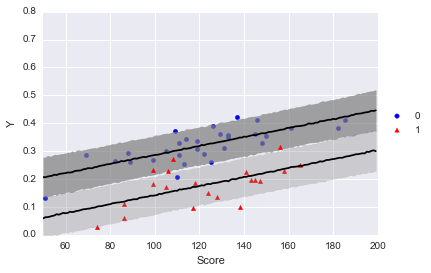

In [13]:
idx_a0 = df1.A == 0
df_a0 = df1[idx_a0]
idx_a1 = df1.A == 1
df_a1 = df1[idx_a1]
ax1= plt.scatter(df_a0.Score, df_a0.Y, marker="o", color="b",label="0")
ax1= plt.plot(Score_new, pred0_med, "-", color="black")
ax1= plt.fill_between(Score_new, pred0_low80, pred0_upp80, color='gray', alpha=0.7) 
ax1= plt.scatter(df_a1.Score, df_a1.Y, marker="^", color="r",label="1")
ax1= plt.plot(Score_new, pred1_med, "-", color="black")
ax1= plt.fill_between(Score_new, pred1_low80, pred1_upp80, color='gray', alpha=0.3) 
ax1= plt.xlim(50,200)
ax1= plt.ylim(0,0.8)
ax1= plt.xlabel("Score")
ax1= plt.ylabel("Y")
ax1= plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##### fig 5.3 

In [14]:
y_obsv = df1.Y
y_pred = ms["y_pred"]

In [15]:
y_pred.shape

(4000, 50)

In [16]:
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(ms['y_pred'], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df1, df_qua], axis=1)
d0 = d[d.A == 0]
d1 = d[d.A == 1]

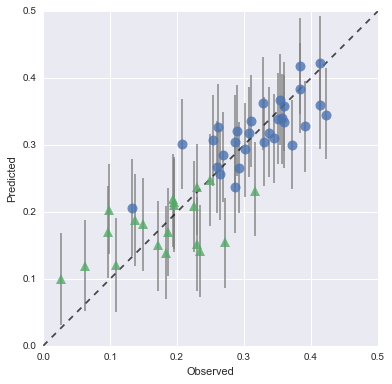

In [17]:
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([0,0.5], [0,0.5], 'k--', alpha=0.7)
ax.errorbar(d0.Y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.Y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

##### fig. 5.4(若干本当異なる)

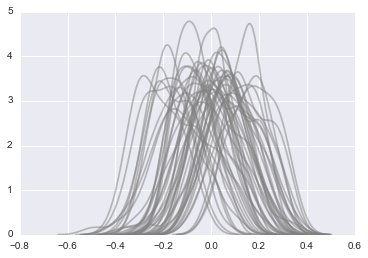

In [18]:
y_tmp_for_map = []
for n in range(len(df1)):
    y_pred_tmp = y_pred[n]
    y_obsv_tmp = y_obsv[n]
    y_tmp = y_obsv_tmp - y_pred_tmp
    y_tmp_for_map.append(y_tmp)
    sns.kdeplot(y_tmp,  kernel="gau", color="gray", alpha=0.5)

In [19]:
# map推定値を求める。もっとスマートな方法はないものか。
import statsmodels.api as sm
map_list = []
for arr in y_tmp_for_map:
    kde = sm.nonparametric.KDEUnivariate(arr)
    kde.fit()
    val_peak = kde.support[kde.density.argmax()]
    map_list.append(val_peak)

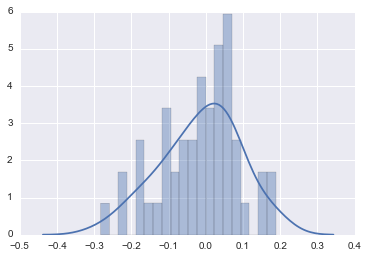

In [20]:
sns.distplot(map_list,bins=20)

##### fig. 5.5

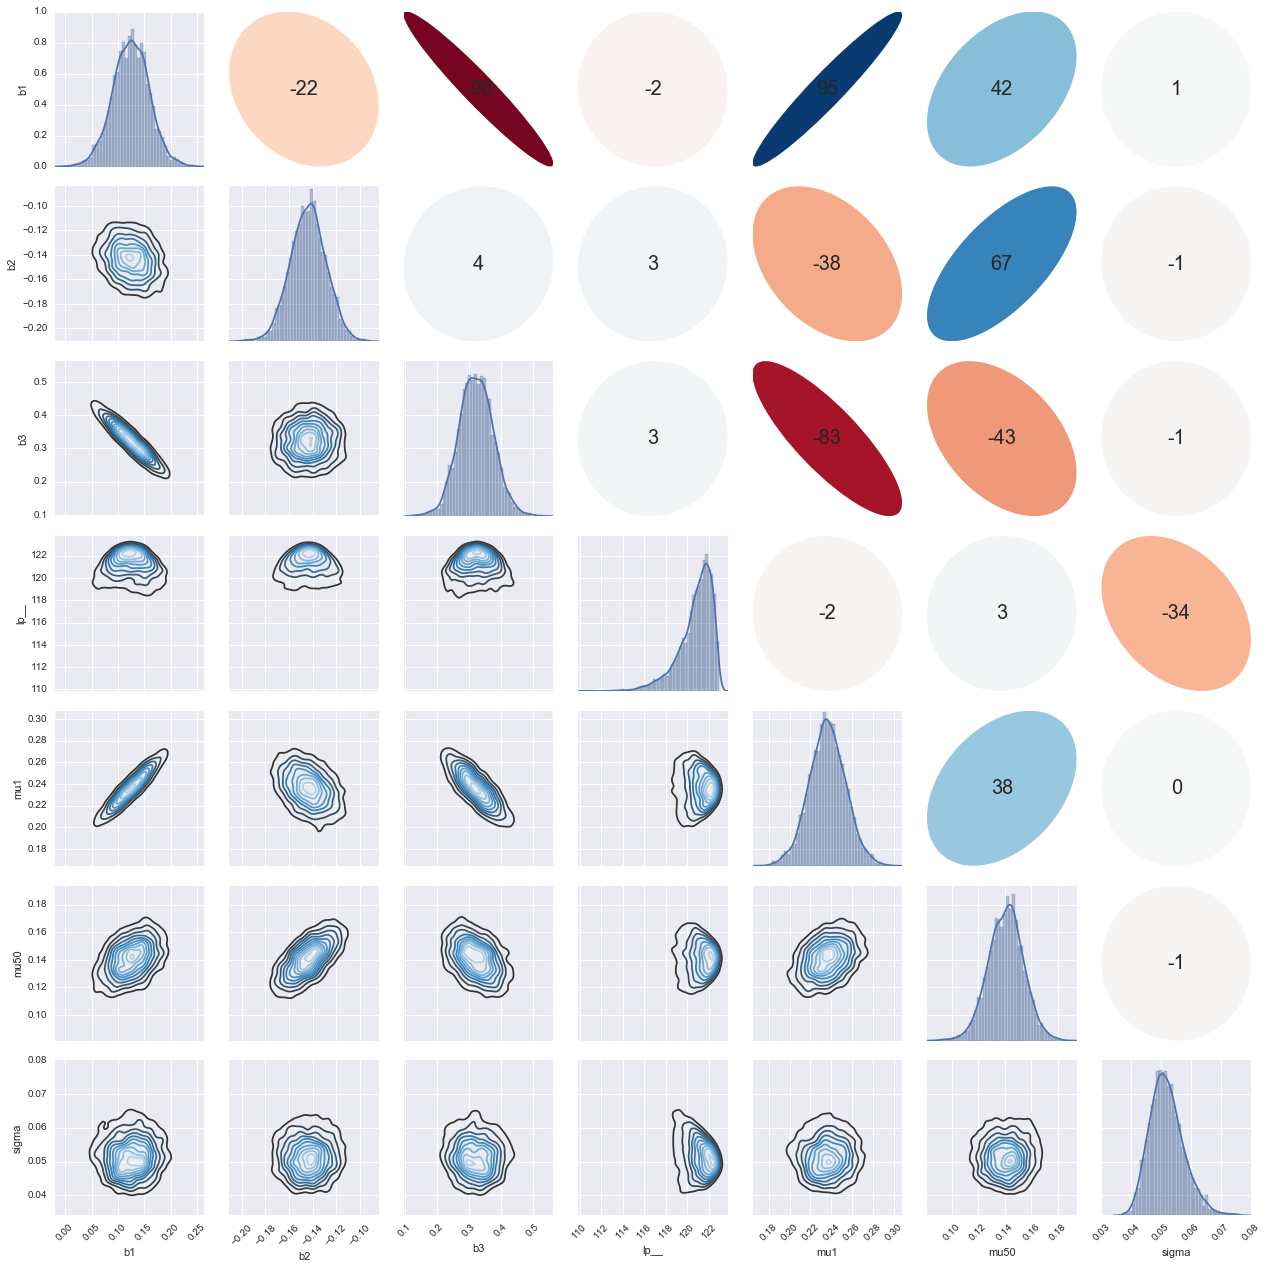

In [21]:
df_tmp = pd.DataFrame({"b1": ms["b1"], "b2": ms["b2"], "b3": ms["b3"], "sigma": ms["sigma"], "mu1": ms["mu"].T[0], "mu50": ms["mu"].T[49], "lp__":ms["lp__"]})
g = sns.PairGrid(df_tmp, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot)
# 下三角成分
g.map_lower(sns.kdeplot, cmap='Blues_d')
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

### 5.2 二項ロジスティック回帰

In [22]:
df2 = pd.read_csv("input/data-attendance-2.txt")
df2["ratio"] = df2.Y / df2.M

In [23]:
df2.head()

,PersonID,A,Score,M,Y,ratio
0,1,0,69,43,38,0.883721
1,2,1,145,56,40,0.714286
2,3,0,125,32,24,0.750000
3,4,1,86,45,33,0.733333
4,5,1,158,33,23,0.696970


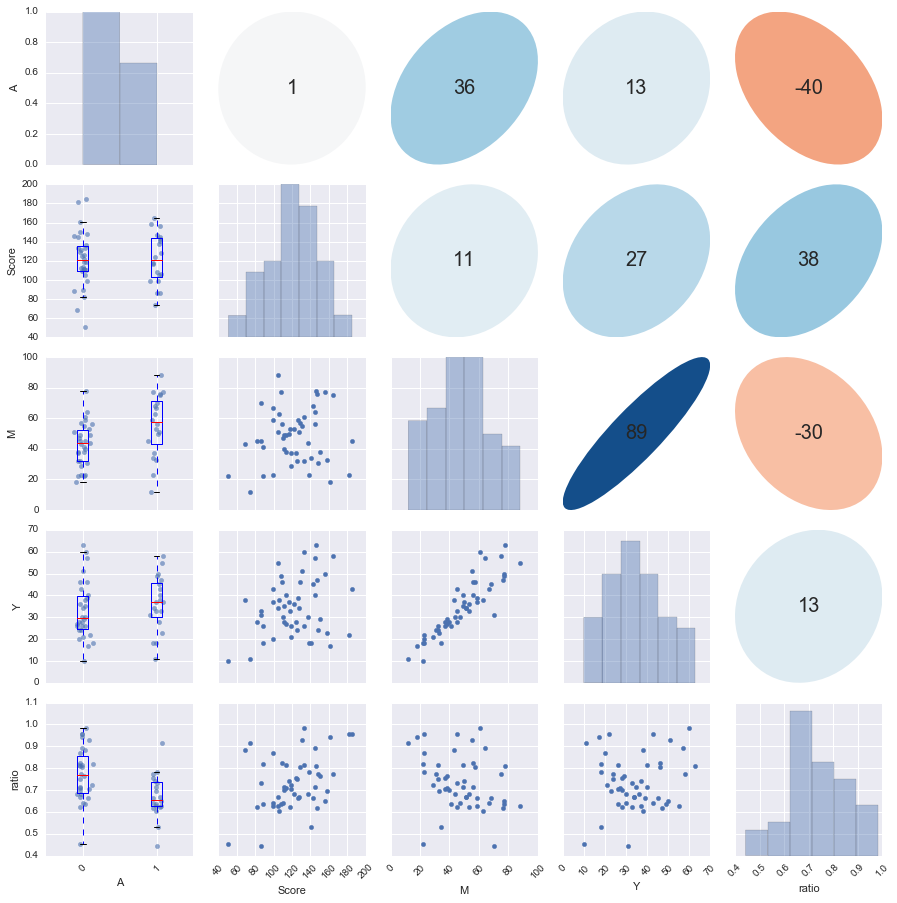

In [24]:
g = sns.PairGrid(df2.iloc[:,1:], diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(d.comb)
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

In [25]:
data54 = {"N":len(df2), "A":df2.A, "Score":df2.Score/200, "Y":df2.Y, "M":df2.M}
fit52 = pystan.stan(file="stan/model5-4.stan", data=data54, seed=1234)

In [26]:
fit52

Inference for Stan model: anon_model_bc0f2141b5b3bd53d2d0372f0c2c476d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  9.2e-3   0.22  -0.34  -0.06   0.09   0.23   0.52    580   1.01
b2          -0.62  3.3e-3   0.09   -0.8  -0.69  -0.62  -0.56  -0.44    836    1.0
b3           1.91    0.01   0.36   1.21   1.67   1.91   2.14   2.61    599   1.01
q[0]         0.68  9.8e-4   0.02   0.63   0.66   0.68   0.69   0.73    620    1.0
q[1]          0.7  5.6e-4   0.02   0.67   0.69    0.7   0.71   0.73    851    1.0
q[2]         0.78  3.8e-4   0.01   0.76   0.77   0.78   0.79   0.81   1022    1.0
q[3]         0.57  7.9e-4   0.02   0.53   0.56   0.57   0.59   0.61    771    1.0
q[4]         0.73  6.7e-4   0.02   0.69   0.71   0.73   0.74   0.76    755    1.0
q[5]          0.8  3.8e-4   0.01   0.77   0.79    0.8    0.8   0.82   103

In [27]:
ms52 = fit52.extract()

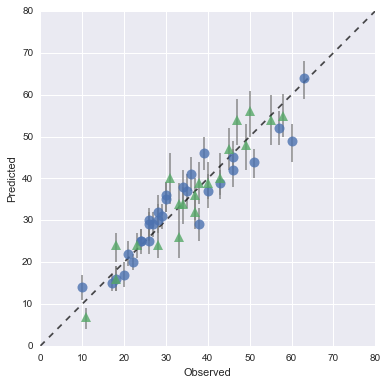

In [77]:
def plot_pred_real(df, ms, cate):
    quantile = [10, 50, 90]
    colname = ['p' + str(x) for x in quantile]
    df_qua = pd.DataFrame(np.percentile(ms[cate], q=quantile, axis=0).T, columns=colname)
    d = pd.concat([df, df_qua], axis=1)
    d0 = d[d.A == 0]
    d1 = d[d.A == 1]
    palette = sns.color_palette()
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot([0,80], [0,80], 'k--', alpha=0.7)
    ax.errorbar(d0.Y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
        fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
    ax.errorbar(d1.Y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
        fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
    ax.set_aspect('equal')
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    plt.show()

plot_pred_real(df2, ms52, 'y_pred')

### 5.3 ロジスティック回帰

In [29]:
df3 = pd.read_csv("input/data-attendance-3.txt")
df3.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [30]:
pd.pivot_table(df3[["Weather", "Y"]], index="Weather", columns="Y",aggfunc=len)

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [31]:
df3["weight"] = df3.Weather.map({"A":0, "B":0.2, "C":1})

In [32]:
data53 = {"I": len(df3), "A":df3.A, "Score":df3.Score/200, "W":df3.weight, "Y":df3.Y}
fit53 = pystan.stan(file="stan/model5-5.stan", data=data53, seed=1234)

In [33]:
fit53

Inference for Stan model: anon_model_46280bc71fd1418522fca2b75941952b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]      0.17  8.2e-3   0.23  -0.33   0.01   0.17   0.33   0.61    808    1.0
b[1]     -0.62  3.0e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.44    982    1.0
b[2]      1.96    0.01   0.37   1.28   1.71   1.95    2.2   2.76    830    1.0
b[3]     -0.46  4.0e-3   0.13  -0.71  -0.55  -0.46  -0.38  -0.21   1001    1.0
q[0]      0.68  8.8e-4   0.03   0.63   0.66   0.68    0.7   0.73    834    1.0
q[1]       0.7  8.9e-4   0.03   0.65   0.68    0.7   0.72   0.75    821    1.0
q[2]      0.59  1.2e-3   0.04   0.52   0.57   0.59   0.62   0.66    953    1.0
q[3]       0.7  8.9e-4   0.03   0.65   0.68    0.7   0.72   0.75    821    1.0
q[4]      0.68  8.8e-4   0.03   0.63   0.66   0.68    0.7   0.73    834    1.0
q[5]      0.68  8.8e-

In [34]:
ms53 = fit53.extract()

In [35]:
b1 = ms53["b"][:,0]
b3 = ms53["b"][:,2]

In [36]:
x_range = np.arange(30,200)

def logistic(x):
    return 1 / (1 + np.exp(-x))

def get_quantile(x):
    q_mcmc = b1 + b3*x/200
    qua = np.percentile(q_mcmc, [10,50,90])
    return [qua[0], qua[1], qua[2]]

df_p = pd.DataFrame([get_quantile(x) for x in x_range],columns=["p10", "p50", "p90"]).pipe(lambda df:logistic(df))

(30, 200)

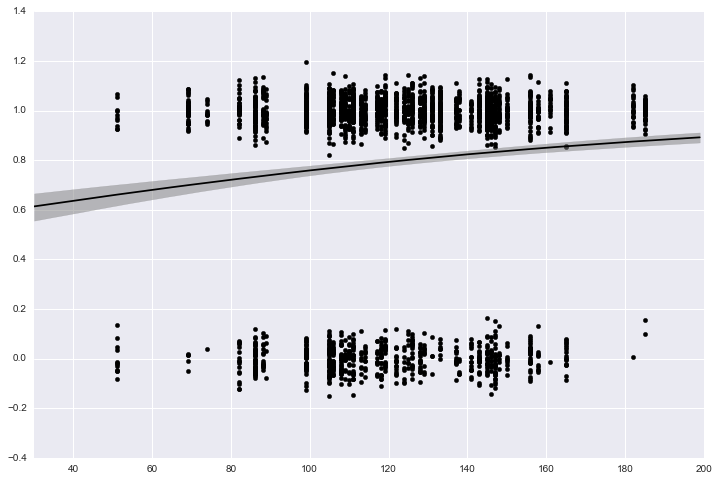

In [37]:
df3_y1 = df3[df3.Y == 1]
df3_y0 = df3[df3.Y == 0]
y_norm_1 = 1 + np.random.normal(scale=0.05, size=len(df3_y1))
y_norm_0 = 0  + np.random.normal(scale=0.05, size=len(df3_y0))
plt.figure(figsize=(12,8))
plt.scatter(df3_y0.Score, y_norm_0, color="black")
plt.scatter(df3_y1.Score, y_norm_1, color="black")
# sns.swarmplot(x="Score", y="Y", data=df3)
plt.plot(x_range, df_p.p50, "-", color="black")
plt.fill_between(x_range, df_p.p10, df_p.p90, color='gray', alpha=0.5)
plt.xlim(30,200)

In [38]:
mcmc_q = ms53["q"].T

In [39]:
mcmc_q_med = [np.percentile(q,50) for q in mcmc_q]

In [40]:
df3["q"] = mcmc_q_med
df3["y_cate"] = df3.Y.astype("category")

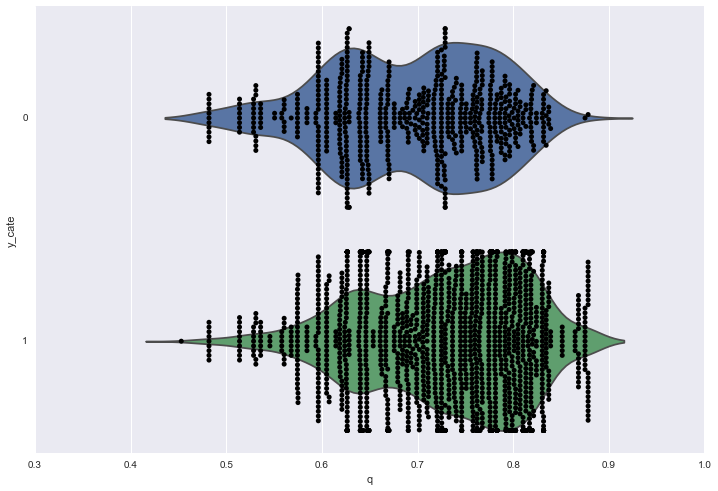

In [41]:
plt.figure(figsize=(12,8))
sns.violinplot(x="q", y="y_cate", data=df3, inner=None)
sns.swarmplot(x="q", y="y_cate", data=df3, color="black")

汚いけど気にしない

### 5.4 ポワソン回帰

In [42]:
df4 = pd.read_csv("input/data-attendance-2.txt")

In [43]:
data56 = {"N":len(df4), "A":df4.A, "Score":df4.Score/200, "M":df4.M}
fit54 = pystan.stan(file="stan/model5-6.stan", data=data56, seed=1234)

In [44]:
fit54

Inference for Stan model: anon_model_b226be864bf5930178b5f63405cc1122.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         3.57  3.5e-3   0.09   3.39   3.51   3.57   3.64   3.76    729    1.0
b[1]         0.27  1.5e-3   0.04   0.18   0.24   0.27   0.29   0.34    756    1.0
b[2]         0.29  5.4e-3   0.15 2.0e-3   0.19    0.3   0.39   0.58    721    1.0
lambda[0]   39.52    0.07   1.89  35.89  38.23  39.46  40.76  43.33    773    1.0
lambda[1]    57.6    0.06   1.97  53.86  56.23  57.58  58.93  61.58    937    1.0
lambda[2]   42.88    0.04   1.18  40.52  42.06  42.88   43.7  45.16    992    1.0
lambda[3]   52.82    0.08   2.14  48.69  51.37  52.77  54.29  56.84    807    1.0
lambda[4]   58.72    0.08   2.32  54.29  57.14  58.71  60.25  63.36    885    1.0
lambda[5]   43.39    0.04   1.23  40.91  42.55  43.39  44.23  45.86    98

In [84]:
df4.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


In [45]:
ms54 = fit54.extract()

In [46]:
b = ms54["b"].T
b1, b2, b3 = (np.percentile(x, 50) for x in b)

In [47]:
(np.exp(b1) * np.exp(b2) * np.exp(b3 * 150 / 200)) / (np.exp(b1) * np.exp(b2) * np.exp(b3 * 50 / 200))

1.1589923932910613

#### 練習問題

In [59]:
# (1)
mcmc_sample_eps = np.array(df1.Y)[:, np.newaxis] - ms["y_pred"].T

In [66]:
# 一応10, 50, 90%点を確かめる。
[np.percentile(ep, [10,50,90]) for ep in mcmc_sample_eps]

[array([-0.0191479 ,  0.04825932,  0.11764144]),
 array([-0.08628651, -0.01870999,  0.05131254]),
 array([-0.13060945, -0.06539585,  0.00200349]),
 array([-0.08135201, -0.01132509,  0.05813097]),
 array([-0.07204726, -0.00725772,  0.0651598 ]),
 array([-0.05725623,  0.01102312,  0.07828077]),
 array([-0.04093353,  0.02606101,  0.09065048]),
 array([-0.09238273, -0.0247388 ,  0.0469064 ]),
 array([-0.01320016,  0.05280154,  0.11841195]),
 array([-0.06419951,  0.00142346,  0.06887783]),
 array([-0.05098917,  0.01668802,  0.0843541 ]),
 array([ 0.00830211,  0.07857589,  0.14386934]),
 array([-0.04940519,  0.01592714,  0.08145045]),
 array([-0.08710883, -0.01784545,  0.05093243]),
 array([ 0.0037616 ,  0.07095302,  0.13626016]),
 array([-0.02527198,  0.04397297,  0.11242821]),
 array([-0.03113011,  0.03512731,  0.10120261]),
 array([-0.06018696,  0.00801562,  0.07579325]),
 array([-0.07929343, -0.00961236,  0.06232347]),
 array([ 0.01201856,  0.08411554,  0.15223763]),
 array([-0.12614728,

In [63]:
# (2)
data_ex2 = {'N':len(df1),'A':df1["A"], 'Score':df1["Score"]/200,'Y':df1["Y"]}
fit = pystan.stan("stan/exercise2.stan",  data=data_ex2, seed=1234)

In [65]:
fit

Inference for Stan model: anon_model_a1fcc9b764bbb176820f4fdc699abdd5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.12  1.1e-3   0.03   0.06    0.1   0.12   0.15   0.19    871    1.0
b2          -0.14  5.0e-4   0.02  -0.17  -0.15  -0.14  -0.13  -0.11    922    1.0
b3           0.32  1.8e-3   0.05   0.22   0.29   0.32   0.36   0.43    868    1.0
sigma        0.05  1.8e-4 5.5e-3   0.04   0.05   0.05   0.06   0.06    919    1.0
mu[0]        0.24  5.7e-4   0.02    0.2   0.22   0.24   0.25   0.27    874    1.0
mu[1]        0.22  4.2e-4   0.01   0.19   0.21   0.22   0.22   0.24   1028    1.0
mu[2]        0.33  2.9e-4 9.5e-3   0.31   0.32   0.33   0.33   0.35   1117    1.0
mu[3]        0.12  4.7e-4   0.01   0.09   0.11   0.12   0.13   0.15   1017    1.0
mu[4]        0.24  4.9e-4   0.02   0.21   0.23   0.24   0.25   0.27    98

In [68]:
# (3)
pd.pivot_table(df3[["A", "Y"]], index="A", columns="Y", aggfunc=len)

Y,0,1
A,,
0,288,994
1,386,728


In [69]:
df3.head(2)

,PersonID,A,Score,Weather,Y,weight,q,y_cate
0,1,0,69,B,1,0.2,0.679373,1
1,1,0,69,A,1,0.0,0.699195,1


In [79]:
data_ex4 = {"I": len(df3), "A":df3.A, "Score":df3.Score/200, "W":df3.Weather.map({"A":1,"B":2,"C":3}), "Y":df3.Y}
fit_ex4 = pystan.stan(file="stan/exercise4.stan", data=data_ex4, seed=1234, pars=["b", "bw2", "bw3"])

In [80]:
fit_ex4

Inference for Stan model: anon_model_b70e539976c38228572453b03e0fce09.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]   0.26  7.7e-3   0.23  -0.19    0.1   0.26   0.42   0.71    917    1.0
b[1]  -0.63  2.9e-3   0.09  -0.81  -0.69  -0.62  -0.56  -0.44   1053    1.0
b[2]   1.98    0.01   0.36   1.27   1.73   1.98   2.22   2.69    906    1.0
bw2   -0.38  3.4e-3   0.11  -0.59  -0.45  -0.38  -0.31  -0.16    986    1.0
bw3    -0.5  4.0e-3   0.13  -0.75  -0.58   -0.5  -0.41  -0.24   1002    1.0
lp__  -1379    0.06   1.63  -1383  -1380  -1379  -1378  -1377    744    1.0

Samples were drawn using NUTS(diag_e) at Fri Nov 18 22:59:23 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [81]:
df4.head()

,PersonID,A,Score,M,Y
0,1,0,69,43,38
1,2,1,145,56,40
2,3,0,125,32,24
3,4,1,86,45,33
4,5,1,158,33,23


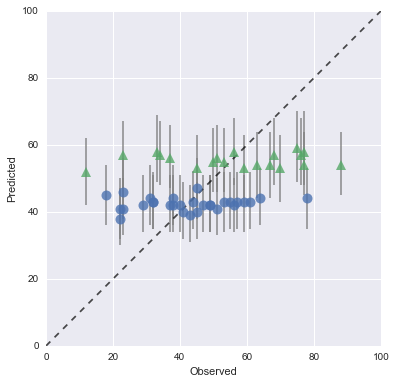

In [86]:
# (5)
# plot_pred_real(df4, ms54, "m_pred")
# df4
# ms54
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(ms54["m_pred"], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df4, df_qua], axis=1)
d0 = d[d.A == 0]
d1 = d[d.A == 1]
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([0,100], [0,100], 'k--', alpha=0.7)
ax.errorbar(d0.M, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.M, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')



観測値が低い・高いところで、予測が外れている。説明できていない。

In [87]:
# (6)
df_ex6 = pd.read_csv("input/data3a.csv")
df_ex6.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [95]:
print(df_ex6.f.unique())
df_ex6.describe()

['C' 'T']


,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


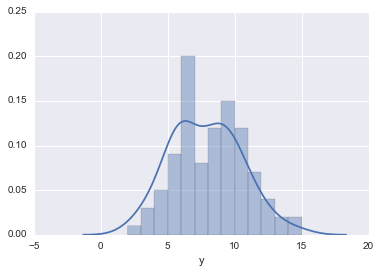

In [94]:
sns.distplot(df_ex6.y, bins=13)

In [99]:
data_ex6 = {"N":len(df_ex6), "X":df_ex6.x, "Y":df_ex6.y, "f":df_ex6.f.map({"C":0, "T":1})}
fit_ex6 = pystan.stan(file="stan/exercise6.stan", data=data_ex6, seed=1234)

In [100]:
fit_ex6

Inference for Stan model: anon_model_7e7cfd6adc24279dca90a849434f2c81.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]         1.24    0.01   0.36   0.54   1.01   1.25   1.48   1.95    612    1.0
b[1]         0.08  1.5e-3   0.04   0.01   0.06   0.08   0.11   0.15    603    1.0
b[2]        -0.03  2.9e-3   0.07  -0.19  -0.08  -0.03   0.01   0.11    637    1.0
y_pred[0]    6.85    0.07   2.68    2.0    5.0    7.0    9.0   12.0   1323    1.0
y_pred[1]    7.51    0.08   2.77    3.0    6.0    7.0    9.0   13.0   1334    1.0
y_pred[2]    7.56    0.08   2.79    3.0    6.0    7.0    9.0   13.0   1330    1.0
y_pred[3]    7.34    0.08   2.77    3.0    5.0    7.0    9.0   13.0   1334    1.0
y_pred[4]    7.98    0.08   2.87    3.0    6.0    8.0   10.0   14.0   1320    1.0
y_pred[5]    6.82    0.07   2.67    2.0    5.0    7.0    9.0   12.0   131

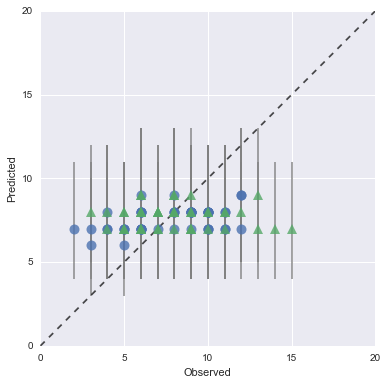

In [103]:
msex6 = fit_ex6.extract()
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(msex6["y_pred"], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df_ex6, df_qua], axis=1)
d0 = d[d.f == "C"]
d1 = d[d.f == "T"]
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([0,20], [0,20], 'k--', alpha=0.7)
ax.errorbar(d0.y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

In [106]:
# (7)
df_ex7 = pd.read_csv("input/data4a.csv")
df_ex7.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [108]:
df_ex7.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


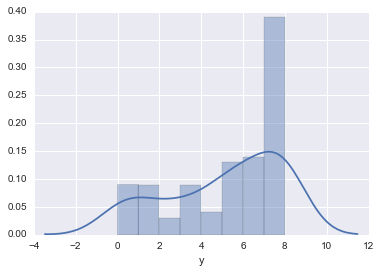

In [111]:
sns.distplot(df_ex7.y,bins=8)

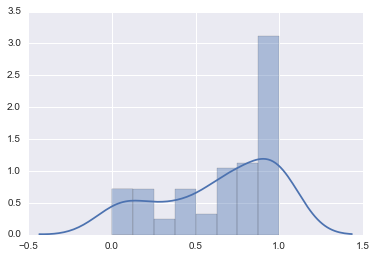

In [113]:
sns.distplot(df_ex7.y / df_ex7.N,bins=8)

In [115]:
data_ex7 = {"I":len(df_ex7), "X":df_ex7.x, "N":df_ex7.N, "Y":df_ex7.y, "f":df_ex7.f.map({"C":0, "T":1})}
fit_ex7 = pystan.stan(file="stan/exercise7.stan", data=data_ex7, seed=1234)

In [116]:
fit_ex7

Inference for Stan model: anon_model_94418d10a71faedf1d44d5a6c17f7b02.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]       -19.61    0.07   1.43  -22.6 -20.55 -19.61 -18.62 -16.83    447    1.0
b[1]         1.96  6.6e-3   0.14   1.69   1.86   1.96   2.05   2.25    450    1.0
b[2]         2.02 10.0e-3   0.24   1.57   1.87   2.02   2.18    2.5    561    1.0
q[0]         0.38  1.2e-3   0.03   0.32   0.36   0.38    0.4   0.45    751    1.0
q[1]         0.72  9.1e-4   0.03   0.66    0.7   0.72   0.74   0.77    923    1.0
q[2]         0.83  7.9e-4   0.02   0.79   0.82   0.83   0.85   0.87    778    1.0
q[3]         0.86  7.5e-4   0.02   0.82   0.85   0.86   0.87    0.9    724    1.0
q[4]         0.22  1.2e-3   0.03   0.17    0.2   0.22   0.24   0.29    594    1.0
q[5]         0.09  8.4e-4   0.02   0.06   0.08   0.09    0.1   0.13    49

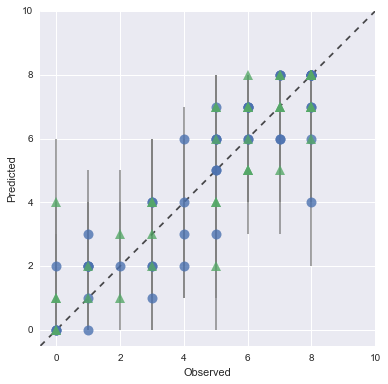

In [119]:
msex7 = fit_ex7.extract()
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(msex7["y_pred"], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df_ex7, df_qua], axis=1)
d0 = d[d.f == "C"]
d1 = d[d.f == "T"]
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([-0.5,10], [-0.5,10], 'k--', alpha=0.7)
ax.errorbar(d0.y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(-0.5, 10)
ax.set_ylim(-0.5, 10)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')